In [1]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE
import geopandas as gpd
import pickle
import matplotlib as mpl

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn


 #----------------
# parameters
#----------------
S = 32
N = 1000
lmbda = 1000
nu = 0.02
num_samples = 225 # 225 #  400 # 400 # 400 # 200
R =  3 # 3 # 3 # 3 # 5
num_gpus = 1
num_cpus = 2


# get directory above
main_dir = "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out') 

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


## Mobile

In [2]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_grid.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['count_norm'] = gdf['count_norm'] * 100
print(gdf.head())
Y = np.array(gdf['count_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.95)
Y[Y>qtile] = qtile


   count  count_before  count_norm  \
0    0.0             0         0.0   
1    0.0             0         0.0   
2    0.0             0         0.0   
3    0.0             0         0.0   
4    0.0             0         0.0   

                                            geometry  
0  POLYGON ((7649981.161 2531547.755, 7654981.161...  
1  POLYGON ((7654981.161 2531547.755, 7659981.161...  
2  POLYGON ((7659981.161 2531547.755, 7664981.161...  
3  POLYGON ((7659981.161 2536547.755, 7664981.161...  
4  POLYGON ((7654981.161 2536547.755, 7659981.161...  


In [3]:
np.quantile(Y,0.95)

163.98322422258593

In [4]:
# get SURE parameters
fto = os.path.join(data_out, 'india_mobile_SURE_95_025_lambda100.pkl')
with open(fto, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']

In [5]:
print(lmbda, nu)

8.181973301598505 0.002741269326583903


In [6]:
resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 1e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [7]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


Execution time: 63.00 seconds


In [8]:
J_grid = results['J']
u = results['u']

/tmp/ipykernel_961213/2168523801.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


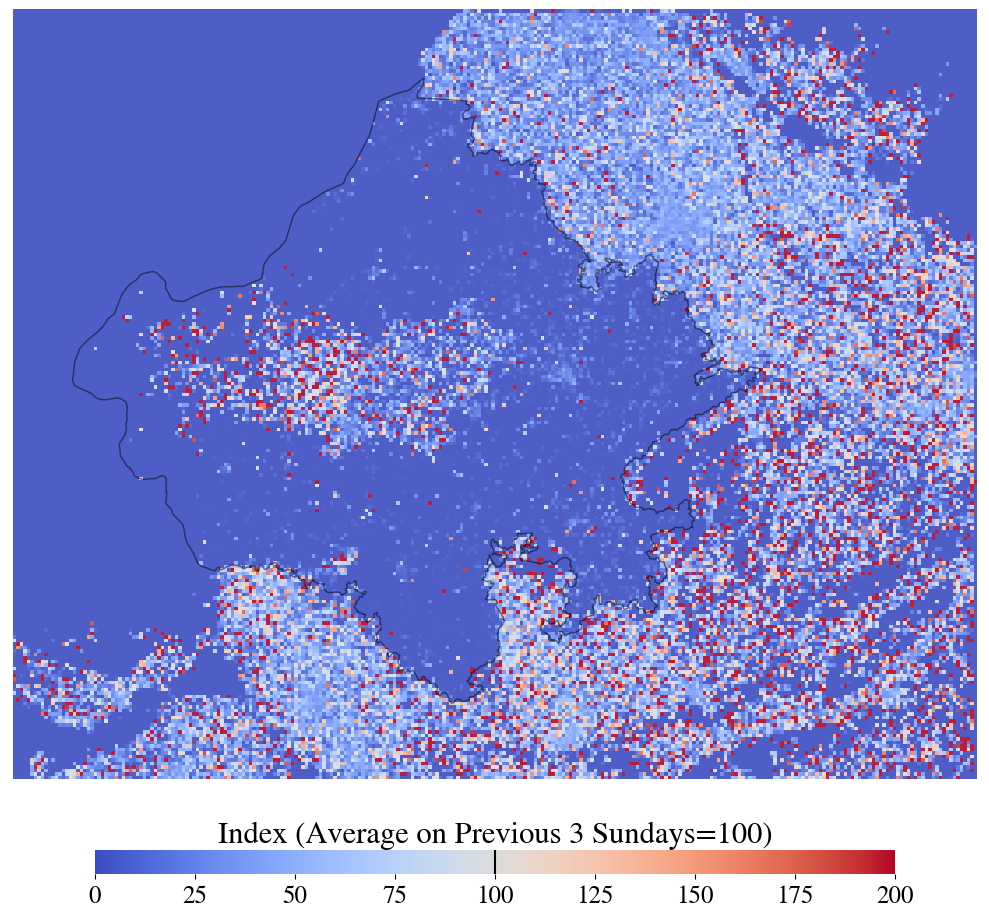

In [40]:
from matplotlib.cm import ScalarMappable

gdf['count_scaled'] = gdf['count_norm'] * 3
# Load the shapefile data
states_gdf = gpd.read_file(os.path.join(data_in, 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs(gdf.crs)


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the data
vmax = 200
im = gdf.plot(column="count_norm", cmap='coolwarm', vmin=0, vmax=vmax, ax=ax, alpha=0.9)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=1, ax=ax, alpha=0.5)



# Create a mappable for colorbar using ScalarMappable
norm = plt.Normalize(vmin=0, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([]) # Need to set_data with an empty array


# Position and add the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)


# Remove padding and axis
ax.set_axis_off()
ax.set_rasterized(True)
ax.margins(0)
ax.axis("equal")


# Set the plot limits to match the defined zoom area
plt.tight_layout()


plt.savefig("india_gridy.pdf", bbox_inches="tight")

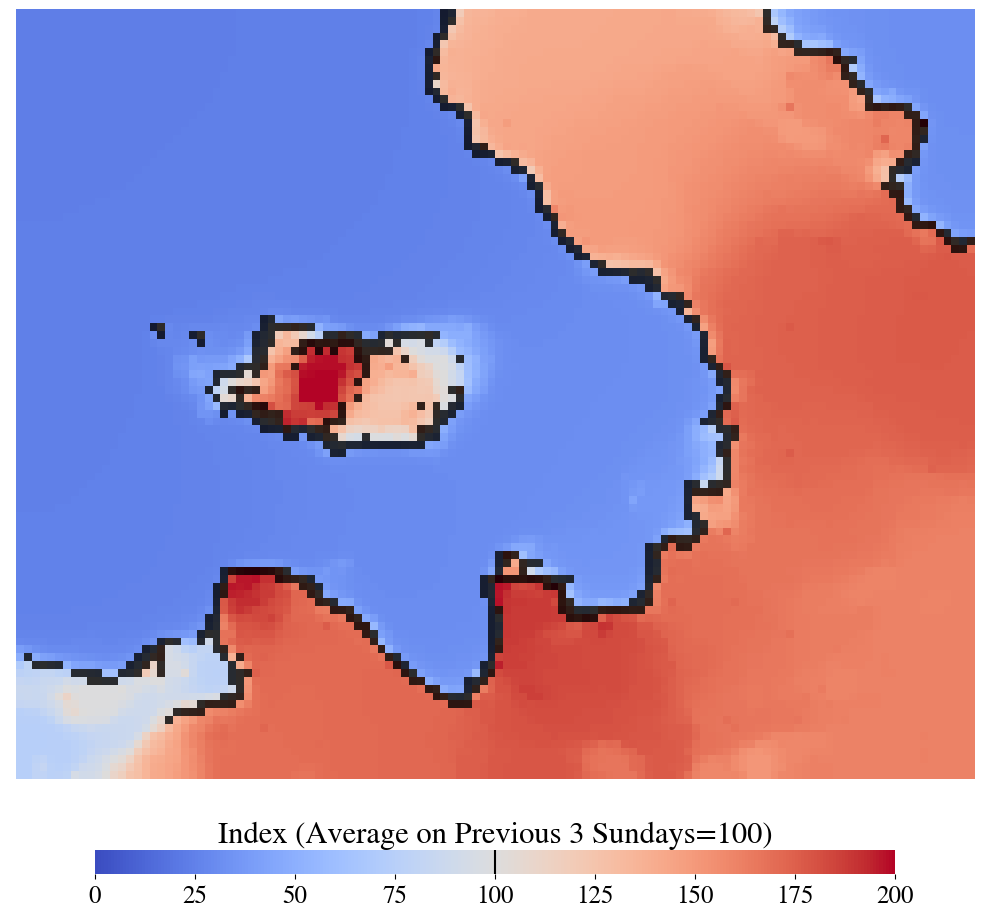

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = plt.imshow(u.T*3, cmap = "coolwarm", origin="lower", vmin=0, vmax=vmax,
               interpolation="none")
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)



# Add a vertical line inside the colorbar at 100
cbar.ax.axvline(100, color='k')

J_temp = J_grid.copy()
J_temp = J_temp.astype(float)
J_temp[J_temp == 0] = np.nan
ax.imshow(J_temp.T, cmap = "binary_r", origin="lower", alpha=0.8)

plt.savefig("india_u.pdf", bbox_inches="tight")

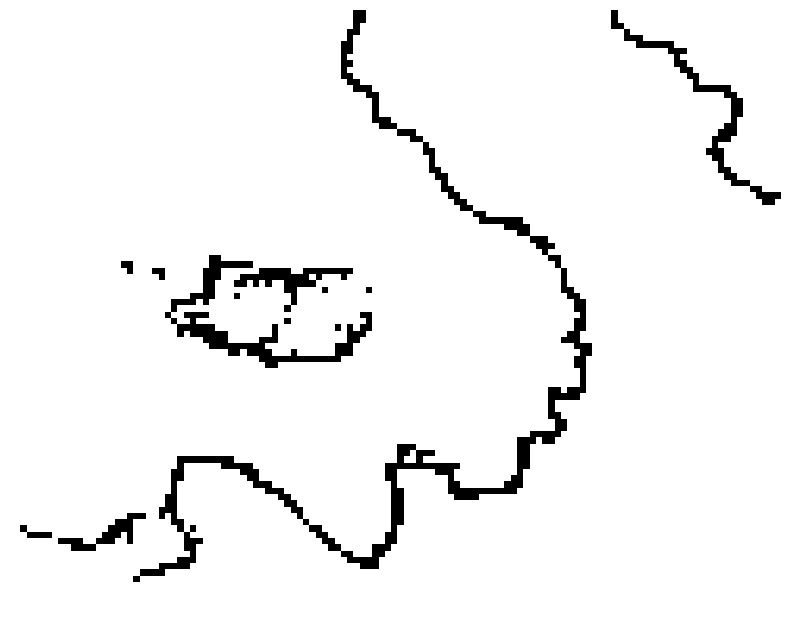

In [11]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

img = ax.imshow(J_grid.T, cmap = "binary", origin="lower")
ax.set_axis_off()
ax.axis("equal")
plt.savefig("india_Jgrid.pdf", bbox_inches="tight")

In [31]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u*3)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

In [32]:
Xplot[(model.grid_x[...,1]*300 > 220) & (model.grid_x[...,0]*300 > 140)] = 0

In [33]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
smoothed_parts = gaussian_filter(Xplot[Xplot != 0], sigma=1)
smoothed_Xplot = Xplot.copy()
smoothed_Xplot[Xplot != 0] = smoothed_parts

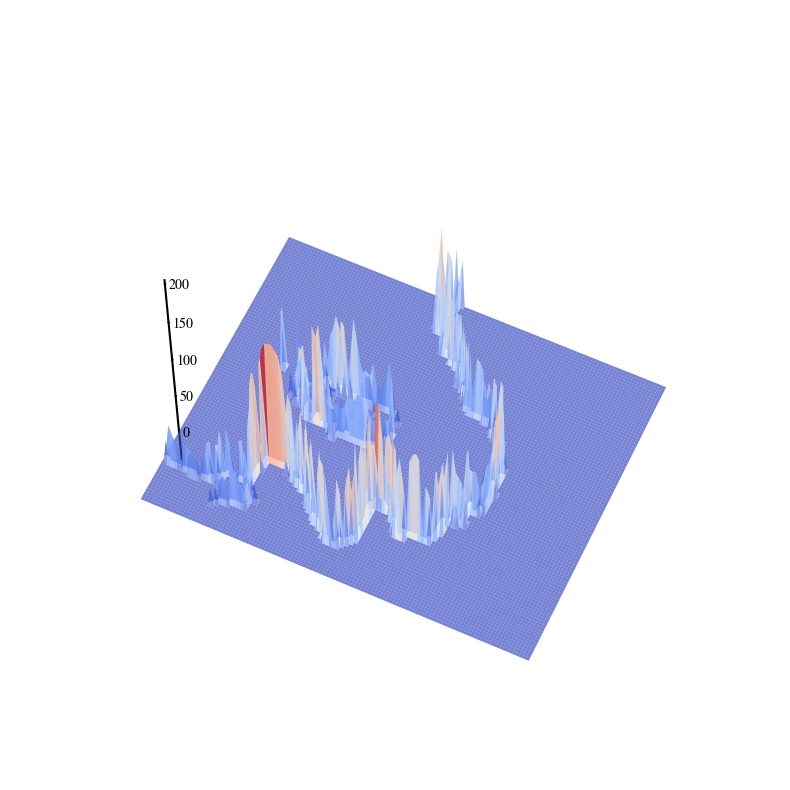

In [35]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cmap = plt.cm.coolwarm
lowest_color = cmap(0.0)
ax.plot_surface(model.grid_x[...,1]*300, model.grid_x[...,0]*300, Xplot, 
                rstride=1, cstride=1, antialiased=True, 
                cmap="coolwarm", edgecolor=(0,0,0,0), alpha=0.7)

# Set z-axis limits
zmin = 0
ax.set_zlim(bottom=zmin)

ax.set_axis_off()
ax.axis("equal")
ax.margins(0)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the artificial z-axis. This example places it at the left front corner.
# You can adjust the X, Y coordinates as needed.
x_start, y_start = 0, 60
z_lim = ax.get_zlim()
ax.plot([x_start, x_start], [y_start, y_start], [z_lim[0], z_lim[1]], color='k')

# Label the z-axis
# ax.text(x_start, y_start, 1.1*z_lim[1], 'Index', fontsize=12)

# Add ticks to the artificial z-axis
number_of_ticks = 5
tick_length = 0.2
z_ticks = np.linspace(0, 200, number_of_ticks)
for z_tick in z_ticks:
    ax.plot([x_start, x_start + tick_length], [y_start, y_start], [z_tick, z_tick], color='k')
    ax.text(x_start + 15 * tick_length, y_start, z_tick, f"{z_tick:.0f}", verticalalignment='center')


# Set the view angle
ax.view_init(elev=60, azim=-65)
plt.tight_layout()

plt.savefig("india_treatmentcurve.pdf", bbox_inches="tight", dpi=300)

## Economic

In [12]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_shops_merged_40K.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['pings_norm'] = gdf['pings_norm'] * 100
print(gdf.head())
Y = np.array(gdf['pings_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.95)
Y[Y>qtile] = qtile

   pings        count  pings_before  count_before  pings_norm  pings_share  \
0  667.0  8716.000000    479.000000   8716.000000  139.248434     0.076526   
1    0.0  6224.666667      3.666667   6224.666667    0.000000     0.000000   
2    0.0     0.000000      0.000000      0.000000    0.000000     0.000000   
3   83.0  6593.000000    204.333333   6593.000000   40.619902     0.012589   
4    0.0  9156.666667      0.000000   9156.666667    0.000000     0.000000   

   pings_share_pre  pings_share_change  pings_share_norm  \
0         0.164869           -0.088343         -0.535839   
1         0.001767           -0.001767         -1.000000   
2         0.000000            0.000000          0.000000   
3         0.092977           -0.080388         -0.864600   
4         0.000000            0.000000          0.000000   

                                            geometry  
0  POLYGON ((7649892.743 2531408.573, 7689892.743...  
1  POLYGON ((7689892.743 2531408.573, 7729892.743...  
2  PO

In [32]:
lmbda = 5
nu = 0.005

In [33]:
resolution = 1/int(np.sqrt(Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [34]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Execution time: 27.55 seconds


In [35]:
J_grid = results['J']
u = results['u']


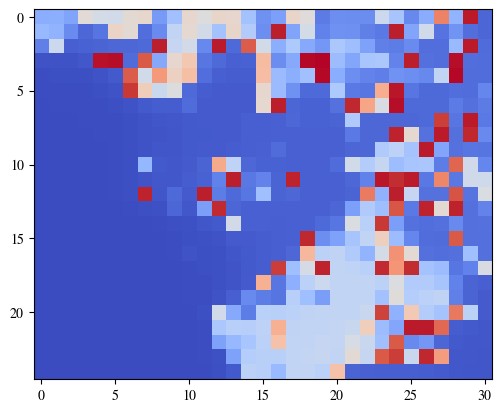

In [36]:
plt.imshow(u.T, cmap="coolwarm", origin="lower")



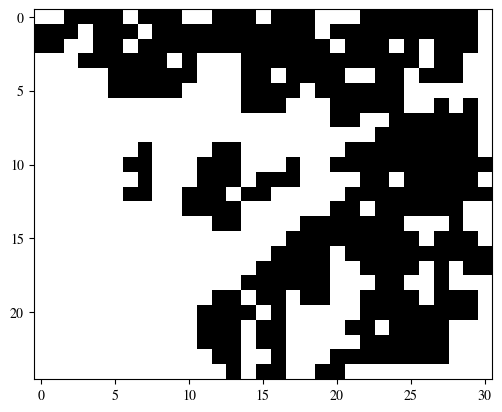

In [37]:
plt.imshow(J_grid.T, cmap="binary", origin="lower")

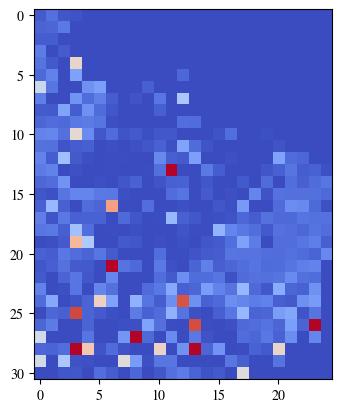

In [11]:
plt.imshow(model.grid_y, cmap="coolwarm", origin="lower")